In [1]:
# Import libraries here
from glob import glob
from plotly.express import scatter_mapbox
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from category_encoders import OneHotEncoder
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline


In [2]:
df = pd.read_csv("data/mexico-city-real-estate-1.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4628 entries, 0 to 4627
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   4628 non-null   object 
 1   property_type               4628 non-null   object 
 2   place_with_parent_names     4628 non-null   object 
 3   lat-lon                     4144 non-null   object 
 4   price                       4538 non-null   float64
 5   currency                    4538 non-null   object 
 6   price_aprox_local_currency  4538 non-null   float64
 7   price_aprox_usd             4538 non-null   float64
 8   surface_total_in_m2         1668 non-null   float64
 9   surface_covered_in_m2       4436 non-null   float64
 10  price_usd_per_m2            1150 non-null   float64
 11  price_per_m2                4249 non-null   float64
 12  floor                       291 non-null    float64
 13  rooms                       136 n

In [3]:
df = df[(df["place_with_parent_names"].str.split("|", expand=True)[2] == "Distrito Federal") & (df["price_aprox_usd"] < 100_000)]

In [4]:
# df[df["surface_covered_in_m2"].quantile([0.1, 0.9])]
low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
df[df["surface_covered_in_m2"].between(low, high)]

operation property_type                      place_with_parent_names  \
1         sell         house         |Iztapalapa|Distrito Federal|México|   
2         sell     apartment            |Tlalpan|Distrito Federal|México|   
11        sell     apartment      |Benito Juárez|Distrito Federal|México|   
14        sell     apartment      |Benito Juárez|Distrito Federal|México|   
17        sell         house     |Álvaro Obregón|Distrito Federal|México|   
...        ...           ...                                          ...   
4596      sell     apartment      |Benito Juárez|Distrito Federal|México|   
4597      sell     apartment         |Iztapalapa|Distrito Federal|México|   
4598      sell     apartment     |Miguel Hidalgo|Distrito Federal|México|   
4599      sell     apartment         |Cuauhtémoc|Distrito Federal|México|   
4605      sell     apartment  |Gustavo A. Madero|Distrito Federal|México|   

                    lat-lon      price currency  price_aprox_local_currency  \
1       19.31033,-99.068557  1512000.0      MXN                  1498321.97   
2      19.279771,-99.234597   926667.0      MXN                   918284.00   
11    23.634501,-102.552788  1784569.0      MXN                  1768425.20   
14      19.36269,-99.150565  1260000.0      MXN                  1248601.52   
17     19.342911,-99.224472   706447.0      MXN                   700222.21   
...                     ...        ...      ...                         ...   
4596   19.375733,-99.139518  1400000.0      MXN                  1387335.08   
4597    19.325608,-99.06112   610500.0      MXN                   604977.09   
4598   19.441043,-99.175585  1550000.0      MXN                  1535978.09   
4599   19.442796,-99.154915   622000.0      MXN                   616373.16   
4605    19.484988,-99.11171   498532.0      MXN                   494021.99   

      price_aprox_usd  surface_total_in_m2  surface_covered_in_m2  \
1            79661.96                  NaN                   80.0   
2            48822.82                  NaN                  100.0   
11           94022.66                  NaN                   57.0   
14           66384.96                  NaN                  103.0   
17           37229.03                  NaN                   90.0   
...               ...                  ...                    ...   
4596         73761.07                  NaN                   85.0   
4597         32165.09                  NaN                   60.0   
4598         81664.04                  NaN                   90.0   
4599         32770.99                  NaN                   50.0   
4605         26265.89                  NaN                   59.0   

      price_usd_per_m2  price_per_m2  floor  rooms  expenses  \
1                  NaN  18900.000000    NaN    NaN       NaN   
2                  NaN   9266.670000    NaN    NaN       NaN   
11                 NaN  31308.228070    NaN    NaN       NaN   
14                 NaN  12233.009709    NaN    NaN       NaN   
17                 NaN   7849.411111    NaN    NaN       NaN   
...                ...           ...    ...    ...       ...   
4596               NaN  16470.588235    NaN    NaN       NaN   
4597               NaN  10175.000000    NaN    NaN       NaN   
4598               NaN  17222.222222    NaN    NaN       NaN   
4599               NaN  12440.000000    NaN    NaN       NaN   
4605               NaN   8449.694915    NaN    NaN       NaN   

                                          properati_url  
1     http://iztapalapa.properati.com.mx/q7t0_venta_...  
2     http://tlalpan.properati.com.mx/qbi4_venta_dep...  
11    http://benito-juarez.properati.com.mx/pdji_ven...  
14    http://benito-juarez.properati.com.mx/onph_ven...  
17    http://alvaro-obregon.properati.com.mx/r3ig_ve...  
...                                                 ...  
4596  http://benito-juarez.properati.com.mx/q9sa_ven...  
4597  http://iztapalapa.properati.com.mx/npfc_venta_...  
4598  http:

In [5]:
df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
df.head()

operation property_type                      place_with_parent_names  \
1       sell         house         |Iztapalapa|Distrito Federal|México|   
2       sell     apartment            |Tlalpan|Distrito Federal|México|   
8       sell         house  |Gustavo A. Madero|Distrito Federal|México|   
11      sell     apartment      |Benito Juárez|Distrito Federal|México|   
14      sell     apartment      |Benito Juárez|Distrito Federal|México|   

                  lat-lon      price currency  price_aprox_local_currency  \
1     19.31033,-99.068557  1512000.0      MXN                  1498321.97   
2    19.279771,-99.234597   926667.0      MXN                   918284.00   
8    19.509359,-99.093272  1600000.0      MXN                  1585525.89   
11  23.634501,-102.552788  1784569.0      MXN                  1768425.20   
14    19.36269,-99.150565  1260000.0      MXN                  1248601.52   

    price_aprox_usd  surface_total_in_m2  surface_covered_in_m2  \
1          79661.96                  NaN                   80.0   
2          48822.82                  NaN                  100.0   
8          84298.37                  NaN                  144.0   
11         94022.66                  NaN                   57.0   
14         66384.96                  NaN                  103.0   

    price_usd_per_m2  price_per_m2  floor  rooms  expenses  \
1                NaN  18900.000000    NaN    NaN       NaN   
2                NaN   9266.670000    NaN    NaN       NaN   
8                NaN  11111.111111    NaN    NaN       NaN   
11               NaN  31308.228070    NaN    NaN       NaN   
14               NaN  12233.009709    NaN    NaN       NaN   

                                        properati_url        lat         lon  
1   http://iztapalapa.properati.com.mx/q7t0_venta_...  19.310330  -99.068557  
2   http://tlalpan.properati.com.mx/qbi4_venta_dep...  19.279771  -99.234597  
8   http://gustavo-a-madero.properati.com.mx/piyr_...  19.509359  -99.093272  
11  http://benito-juarez.properati.com.mx/pdji_ven...  23.634501 -102.552788  
14  http://benito-juarez.properati.com.mx/onph_ven...  19.362690  -99.150565

In [6]:
df.columns[df.isnull().sum()/len(df) > 0.5]

Index(['surface_total_in_m2', 'price_usd_per_m2', 'floor', 'rooms',
       'expenses'],
      dtype='object')

In [7]:
# Build your `wrangle` function
def wrangle(file):
    # Read csv to dataframe
    df = pd.read_csv(file)
    
    # Subset data to return only apartments in Mexico City ("Distrito Federal") that cost less than $100,000
    mask_apt = df["property_type"] == "apartment"
    mask_dist = df["place_with_parent_names"].str.contains("Distrito Federal")
    mask_price = df["price_aprox_usd"] < 100_000
    df = df[mask_apt & mask_dist & mask_price]
    
    # Remove outliers
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_outliers =  df["surface_covered_in_m2"].between(low, high)
    df = df[mask_outliers]
    
    # Create separate "lat" and "lon" columns
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)
    
    # Create a "borough" feature from the "place_with_parent_names" column
    df["borough"] = df["place_with_parent_names"].str.split("|", expand=True)[1]
    df.drop(columns="place_with_parent_names", inplace=True)
    
    # Drop columns that are more than 50% null values.
    columns = df.columns[df.isnull().sum()/len(df) > 0.5]
    df.drop(columns=columns, inplace=True)
    
    # Drop columns containing low- or high-cardinality categorical values
    df.drop(columns=["operation", "property_type", "currency", "properati_url"], inplace=True)
    
    # Drop columns with leakages
    df.drop(columns=["price", "price_aprox_local_currency", "price_per_m2"], inplace=True)
    
    # Drop columns with multicolinearity
#     df.drop(columns="surface_covered_in_m2", inplace=True)
    
    return df

In [8]:
# Use this cell to test your wrangle function and explore the data
files = glob("data/mexico-city-real-estate-*.csv")
dataframes = [wrangle(file) for file in files]
df = pd.concat(dataframes)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5473 entries, 11 to 4618
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        5473 non-null   float64
 1   surface_covered_in_m2  5473 non-null   float64
 2   lat                    5149 non-null   float64
 3   lon                    5149 non-null   float64
 4   borough                5473 non-null   object 
dtypes: float64(4), object(1)
memory usage: 256.5+ KB


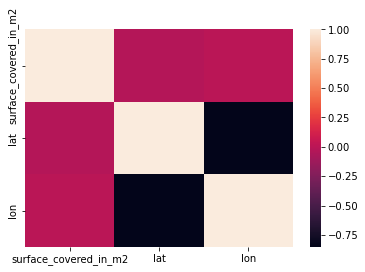

In [9]:
corr = df.drop(columns="price_aprox_usd").corr()
sns.heatmap(corr);

In [10]:
df.select_dtypes("object").nunique()

borough    15
dtype: int64

In [11]:
df = wrangle("data/mexico-city-real-estate-1.csv")
df.shape

(1101, 5)

In [12]:
files = glob("data/mexico-city-real-estate-*.csv")
files

['data\\mexico-city-real-estate-1.csv',
 'data\\mexico-city-real-estate-2.csv',
 'data\\mexico-city-real-estate-3.csv',
 'data\\mexico-city-real-estate-4.csv',
 'data\\mexico-city-real-estate-5.csv']

In [13]:
dataframes = [wrangle(file) for file in files]
df = pd.concat(dataframes)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5473 entries, 11 to 4618
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        5473 non-null   float64
 1   surface_covered_in_m2  5473 non-null   float64
 2   lat                    5149 non-null   float64
 3   lon                    5149 non-null   float64
 4   borough                5473 non-null   object 
dtypes: float64(4), object(1)
memory usage: 256.5+ KB
None


price_aprox_usd  surface_covered_in_m2        lat         lon  \
11         94022.66                   57.0  23.634501 -102.552788   
20         70880.12                   56.0  19.402413  -99.095391   
21         68228.99                   80.0  19.357820  -99.149406   
22         24235.78                   60.0  19.504985  -99.208557   
26         94140.20                   50.0  19.354219  -99.126244   

          borough  
11  Benito Juárez  
20      Iztacalco  
21  Benito Juárez  
22   Azcapotzalco  
26       Coyoacán

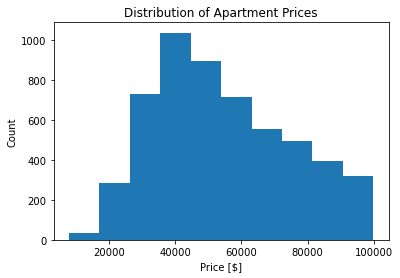

In [15]:
# Build histogram
plt.hist(df["price_aprox_usd"])


# Label axes
plt.xlabel("Price [$]")
plt.ylabel("Count")

# Add title
plt.title("Distribution of Apartment Prices")

# Don't delete the code below 👇
plt.savefig("images/2-5-4.png", dpi=150)


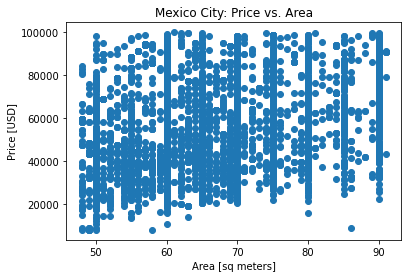

In [16]:
# Build scatter plot
plt.scatter(x=df["surface_covered_in_m2"], y=df["price_aprox_usd"])


# Label axes
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")

# Add title
plt.title("Mexico City: Price vs. Area")

# Don't delete the code below 👇
plt.savefig("images/2-5-5.png", dpi=150)


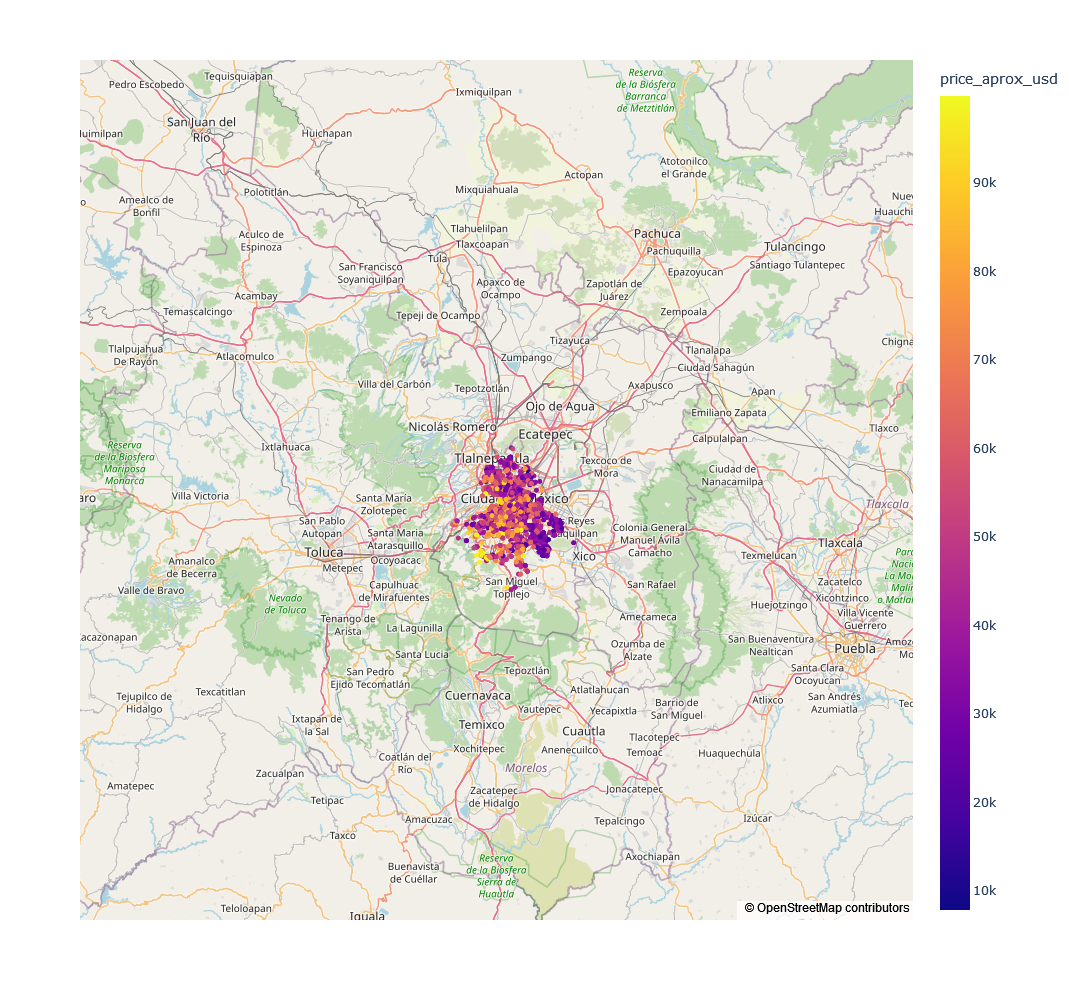

In [17]:
# Plot Mapbox location and price
fig = scatter_mapbox(
    data_frame=df, 
    lat="lat", 
    lon="lon", 
    color="price_aprox_usd",
    width=1000,
    height=1000
)

fig.update_layout(mapbox_style="open-street-map")

fig.show()

In [18]:
# Split data into feature matrix `X_train` and target vector `y_train`.

X_train = df[["surface_covered_in_m2", "lat", "lon", "borough"]]
y_train = df["price_aprox_usd"]

In [19]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean]*len(y_train)
baseline_mae = mean_absolute_error(y_train, y_pred_baseline)
print("Mean apt price:", round(y_mean, 2))
print("Baseline MAE:", round(baseline_mae, 2))

Mean apt price: 54246.53
Baseline MAE: 17239.94


In [20]:
# Build Model
model = make_pipeline(
    OneHotEncoder(),
    SimpleImputer(),
    Ridge()
)
# Fit model
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(cols=['borough'])),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

In [21]:
X_test = pd.read_csv("data/mexico-city-test-features.csv")
print(X_test.info())
X_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041 entries, 0 to 1040
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surface_covered_in_m2  1041 non-null   float64
 1   lat                    986 non-null    float64
 2   lon                    986 non-null    float64
 3   borough                1041 non-null   object 
dtypes: float64(3), object(1)
memory usage: 32.7+ KB
None


surface_covered_in_m2        lat        lon        borough
0                   60.0  19.493185 -99.205755   Azcapotzalco
1                   55.0  19.307247 -99.166700       Coyoacán
2                   50.0  19.363469 -99.010141     Iztapalapa
3                   60.0  19.474655 -99.189277   Azcapotzalco
4                   74.0  19.394628 -99.143842  Benito Juárez

In [22]:
y_test_pred = pd.Series(model.predict(X_test))
y_test_pred.head()

0    53538.366480
1    53171.988369
2    34263.884179
3    53488.425607
4    68738.924884
dtype: float64

In [23]:
coefficients = model.named_steps["ridge"].coef_
features = model.named_steps["onehotencoder"].get_feature_names()
feat_imp = pd.Series(data=[coef for coef in coefficients], index=[feat for feat in features], )
feat_imp

surface_covered_in_m2      291.654156
lat                        478.901375
lon                      -2492.221814
borough_1                13778.188880
borough_2                  405.403127
borough_3                 2459.288646
borough_4                 3737.561001
borough_5                 3275.121061
borough_6               -13349.017448
borough_7                 -350.531990
borough_8               -14166.869486
borough_9                 1977.314718
borough_10               -5609.918629
borough_11               10319.429804
borough_12               -6637.429757
borough_13                 929.857400
borough_14               -5925.666450
borough_15                9157.269123
dtype: float64

In [24]:
feat_imp.sort_values(ascending=False)[:10]

borough_1     13778.188880
borough_11    10319.429804
borough_15     9157.269123
borough_4      3737.561001
borough_5      3275.121061
borough_3      2459.288646
borough_9      1977.314718
borough_13      929.857400
lat             478.901375
borough_2       405.403127
dtype: float64

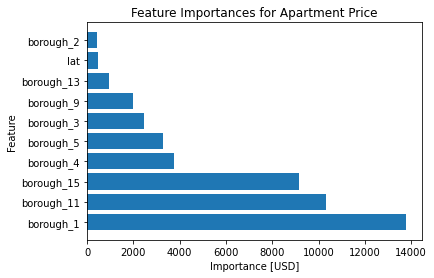

In [25]:
# Build bar chart
feat_imp = feat_imp.sort_values(ascending=False)[:10]
plt.barh(feat_imp.index, feat_imp.values)

# Label axes
plt.xlabel("Importance [USD]")
plt.ylabel("Feature")

# Add title
plt.title("Feature Importances for Apartment Price")

# Don't delete the code below 👇
plt.savefig("images/2-5-13.png", dpi=150)
